In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from numpy import typing as npt

# Our goal is to fine-tune the prediction probabilities sent into Loki. 
# We will explore different ways to backpropagate through the locus of the Fréchet mean. 

In [2]:
# Create random simplex vector of dim K
# Create random tree graph with K nodes (or leaves?)

# BASELINE SANITY CHECK -- get gradients of the simplex vector from 
# cross entropy loss with some random label 
# 
# OUR METHOD -- get gradients of the simplex vector from our method

In [3]:
#### Utility functions... 

def generate_batch(k:int=100, bs:int=1, soft:bool=False) -> torch.FloatTensor:
    ''' 
    k: synthetic observed label space dimension 
    bs: synthetic batch size
    
    returns unnormalized synthetic logits

    Generate a synthetic batch of softmax outputs
    NOTE we want to ultimately obtain gradients for these
    '''
    preds = torch.randn(bs, k, requires_grad=True)#.softmax(dim=1)
    if soft:
        targets = torch.randn(bs, k).softmax(dim=1)
    else:
        targets = torch.empty(bs, dtype=torch.long).random_(k)
    return preds, targets


# Baseline (gradient sanity check)

In [4]:
k = 10
bs = 1024

loss = nn.CrossEntropyLoss()
preds, targets = generate_batch(k=k, bs=bs)
loss = loss(preds, targets)
loss.backward()

print(f"Loss: {loss}")
print(f"Gradient of logits: \n{preds.grad}")

preds.grad = None # clear the gradients

Loss: 2.7404725551605225
Gradient of logits: 
tensor([[ 1.9224e-05,  6.7176e-04,  3.0347e-05,  ...,  5.0783e-05,
          3.2975e-05,  3.6367e-06],
        [ 1.8773e-04,  5.4567e-05,  6.7605e-05,  ..., -9.3582e-04,
          3.4379e-05,  1.9915e-04],
        [ 1.2522e-04,  4.8774e-05,  4.3607e-05,  ...,  4.4643e-05,
         -5.3026e-04,  3.4537e-05],
        ...,
        [ 2.3040e-04,  1.1506e-04,  2.2619e-05,  ...,  9.5830e-05,
          2.8217e-05,  1.2264e-04],
        [ 1.3104e-04,  1.3216e-04,  2.0377e-05,  ...,  7.5179e-05,
         -8.8917e-04,  7.8006e-05],
        [ 3.4768e-05, -9.4152e-04,  8.7884e-05,  ...,  7.0787e-05,
          2.2634e-05,  7.2271e-05]])


Okay cool, so we want something like this where we have logit gradients, but where we're fine-tuning with something that looks more like the Loki prediction rule...

# Idea 1: fine-tune using class-wise probabilities from Loki

Assume we can get the probability vectors that correspond to a certain class under loki (which might be wildly non-unique), then fine tune using this.
Trivially, we have gradients in this case because it's just soft-target training. 

In [5]:
# k = 10
# bs = 4

# loss = nn.CrossEntropyLoss()
# preds, targets = generate_batch(k=k, bs=bs, soft=True)
# output = loss(preds, targets)
# output.backward()

# print(f"Loss: {output}")
# print(f"Gradient of logits: \n{preds.grad}")

# NOTE okay rip, I guess this version of pytorch doesn't support this even though it's in their documentation. Moving on because this idea probably wasn't going to work anyway, due to potentially many distict regions of simplex that correspond to the same classes. Consider an internal node in a tree and all possible paths that pass through that node. 

# Idea 2: crude Euclidean approximation using MDS

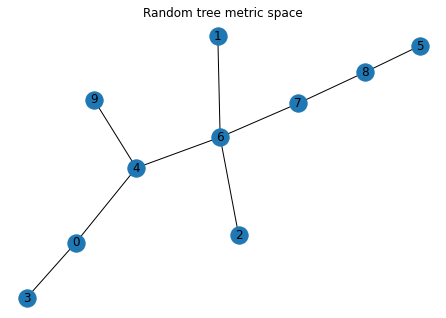

In [6]:
T = nx.random_tree(n=k, seed=0)
nx.draw(T, with_labels=True)
plt.title("Random tree metric space")
plt.show()

Run MDS

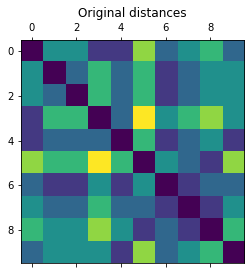

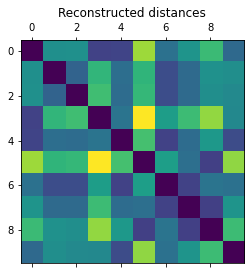

Embedding reconstruction error: 0.1220


In [7]:
distances = nx.floyd_warshall_numpy(T)

plt.matshow(distances)
plt.title("Original distances")
plt.show()

embedding_dim = 4
embedder = MDS(n_components=embedding_dim, dissimilarity='precomputed')
y_emb = embedder.fit_transform(distances)

reconstructed_distances = cdist(y_emb, y_emb)
plt.matshow(reconstructed_distances)
plt.title("Reconstructed distances")
plt.show()

# MAE of reconstructed distances. Not terrible, not amazing. 
emb_rec_err = np.mean(np.abs(reconstructed_distances - distances))
print(f"Embedding reconstruction error: {emb_rec_err:.4f}")

Recall that we want to set up the fine tuning problem so that we can try to reconstruct held-out clases that are in the locus of the held-in classes... 

Let's just try to reconstruct the top three nodes with the highest degree in our random tree for now. We know that at leas the top node is in the locus of the rest of the tree, for nontrivial trees. 

In [8]:
top_k = 3
assert(top_k <= k)

sortlist = sorted(T.degree, key=lambda x: x[1], reverse=True)
in_locus_labels = [sortlist[i][0] for i in range(top_k)]

Filter our dataset in the correct way so that we can create our in-locus fine tuning problem

In [9]:
# Generate fine tuning dataset by filtering: 
# axis 0 of X,Y by in_locus_labels and
# axis 1 of X the complement of in_locus_labels
# NOTE this will be reused for most of our methods

preds, targets = generate_batch(k=k, bs=bs)

ft_preds = []
ft_targets = []
locus_boundary = np.sort(list(set(np.arange(k)) - set(in_locus_labels)))

for i in range(bs):
    if targets[i] in in_locus_labels:
        ft_preds.append(preds[i])
        ft_targets.append(targets[i])

ft_preds = torch.stack(ft_preds)[:, locus_boundary]
ft_targets = torch.stack(ft_targets)

In [10]:
def euclidean_relaxed_objective_with_logits(
        input: torch.FloatTensor, 
        target: torch.LongTensor, 
        locus_bd: torch.LongTensor, 
        embedding: torch.LongTensor) -> torch.FloatTensor:
    '''
    preds: prediction logits
    targets: indices of the targets
    locus_boundary: the classes that we use to reconstruct the targets
    embedding: naïve MDS embedding of the metric space

    returns the loss. 
    '''
    rec = input.softmax(dim=1) @ y_emb[locus_bd]
    diff = y_emb[target] - rec
    rec_dist = torch.linalg.norm(diff, dim=1) ** 2
    loss = torch.mean(rec_dist)
    return loss


y_emb = torch.Tensor(y_emb)
locus_bd = torch.LongTensor(locus_boundary.astype(np.int64))
loss = euclidean_relaxed_objective_with_logits(
    ft_preds, ft_targets, locus_bd, y_emb)
loss.backward()

print(f"Loss: {loss}")
print(f"Gradient of logits: \n{preds.grad}")

preds.grad = None # clear the gradients
ft_preds.grad = None

Loss: 2.886120557785034
Gradient of logits: 
tensor([[ 0.0000, -0.0011, -0.0010,  ...,  0.0003,  0.0033, -0.0029],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


We can also implement a pseudo-Euclidean version of this, but in the interest of time, let's skip it and go straight to the polytope projection approach. 

# Idea 3: polytope projection using SPIGOT

In [11]:
# Since SPIGOT will output hard predictions, we must smooth the predictions
# in order for the cross entropy loss to be well-defined.  
def smooth_hard_preds(preds, k, eps=0.1):
    bs = preds.shape[0]
    rest = (1 / (k - 1)) * eps
    p_rest = torch.ones((bs, k)) * rest
    onehot = torch.eye(k)[preds]
    onehot_scaled = onehot * ((1.0 - eps) - (1 / (k - 1)) * eps)
    p_smooth = p_rest + onehot_scaled
    assert((p_smooth.argmax(dim=1) == preds).all())
    # Important that p_smooth requires grad so that it can be used in SPIGOT
    p_smooth.requires_grad = True
    return p_smooth


loss = nn.NLLLoss() # Use NLL since we don't use logits
with torch.no_grad():
    preds_, targets = generate_batch(k=k, bs=bs)
    preds = smooth_hard_preds(preds_.argmax(dim=1), k=k, eps=0.001)

# NLL loss takes logsoftmax input
loss = loss(torch.log(preds), targets)
loss.backward()

print(f"Loss: {loss}")
print(f"Gradient of logits: \n{preds.grad}")

print(preds.grad.shape)

preds.grad = None # clear the gradients

Loss: 8.002544403076172
Gradient of logits: 
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -8.7891,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -8.7891,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -8.7891],
        [ 0.0000, -8.7891,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
torch.Size([1024, 10])


In [12]:
class LokiStraightThroughEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, probs: torch.FloatTensor, dists: torch.FloatTensor):
        k = dists.shape[0]
        onehot = torch.eye(k)
        
        # Compute S(x) = vector of negative Fréchet variances
        s = -probs @ (dists ** 2)

        # Intermediate decoding step
        with torch.no_grad():
            z_hat_int = s.argmax(dim=1)
            z_hat_onehot = onehot[z_hat_int]

        # Important to ensure that z_hat_smoothed gets gradients from the loss
        z_hat_onehot.requires_grad = True
        return z_hat_onehot
    
    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor):
        return grad_output, None, None
    
def loki_ste_predict(probs, dists):
    loki = LokiStraightThroughEstimator()
    return loki.apply(probs, dists)
        

In [13]:
def proj_simplex(y):
    ''' From http://www.mcduplessis.com/index.php/2016/08/22/fast-projection-onto-a-simplex-python/
    '''
    d = len(y)
    a = torch.ones(d)
    idx = torch.argsort(y)
    evalpL = lambda k: torch.sum((y[idx[k:]] - y[idx[k]])) - 1

    def bisectsearch():
        idxL, idxH = 0, d-1
        L = evalpL(idxL)
        H = evalpL(idxH)
        if L < 0:
            return idxL
        while (idxH - idxL) > 1:
            iMid = int((idxL + idxH) / 2)
            M = evalpL(iMid)
            if M > 0:
                idxL, L = iMid, M
            else:
                idxH, H = iMid, M
        return idxH
        
    k = bisectsearch()
    lam = (torch.sum(y[idx[k:]]) - 1) / (d - k)
    x = np.maximum(0, y - lam)
    return x

class LokiPolytopeEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, probs: torch.FloatTensor,
                dists: torch.FloatTensor, eta: float):
        k = dists.shape[0]
        eta = torch.tensor(eta)
        onehot = torch.eye(k)
        
        # Compute S(x) = vector of negative Fréchet variances
        s = -probs @ (dists ** 2)

        # Intermediate decoding step
        with torch.no_grad():
            z_hat_int = s.argmax(dim=1)
            z_hat_onehot = onehot[z_hat_int]
        ctx.save_for_backward(z_hat_onehot, eta)

        # Important to ensure that z_hat_smoothed gets gradients from the loss
        z_hat_onehot.requires_grad = True
        return z_hat_onehot
    
    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor):
        z_hat_onehot, eta, = ctx.saved_tensors
        z_unproj = z_hat_onehot - (eta * grad_output)

        # TODO project z_unproj onto the unit simplex
        # NOTE that the unit simplex is just the relaxed convex polytope of
        # the one-hot vectors. 
        # NOTE SOFTMAX IS A QUICK-AND-DIRTY NON-OPTIMAL PROJECTION...
        #z_proj = z_unproj.softmax(dim=1)
        # NOTE this is the actual projection but it's slower because it's
        # not batched! 
        b = z_unproj.shape[0]
        z_proj = torch.stack([proj_simplex(z_unproj[i]) for i in range(b)])
        
        delta_s = z_hat_onehot - z_proj
        return delta_s, None, None, None
    
def loki_polytope_predict(probs, dists, eta=0.01):
    loki = LokiPolytopeEstimator()
    return loki.apply(probs, dists, eta)
        

In [14]:
loss = nn.NLLLoss()

logits, targets = generate_batch(k=k, bs=bs)
probs = logits.softmax(dim=1)
preds = loki_polytope_predict(probs, torch.Tensor(distances))

# Apply "label smoothing" to the hard predictions
# so that downstream loss remains well-defined
eps=0.001
smooth_onehot = torch.ones(k, k) * (1 / (k - 1)) * eps
smooth_onehot += torch.eye(k) * ((1 - eps) - (1 / (k - 1)) * eps)
preds_smoothed = preds @ smooth_onehot

# NLL loss takes logsoftmax input
loss = loss(torch.log(preds_smoothed), targets)
loss.backward()

print(f"Loss: {loss}")
print(f"Gradient of logits: \n{logits.grad}")

Loss: 8.269262313842773
Gradient of logits: 
tensor([[-2.7558e-04, -4.6034e-03, -4.4226e-04,  ..., -1.5093e-03,
         -3.7005e-04, -2.5563e-03],
        [-3.4898e-04, -1.2809e-04, -7.6112e-05,  ..., -1.4491e-04,
         -9.9110e-04, -5.9959e-05],
        [-1.5978e-04, -3.6445e-03, -3.9803e-04,  ..., -4.3914e-03,
         -3.6901e-04, -1.4279e-05],
        ...,
        [-6.1420e-04, -7.0558e-04, -1.8778e-04,  ..., -1.2134e-03,
         -1.9822e-04, -6.7477e-04],
        [ 6.6623e-04,  7.9820e-04,  2.6809e-03,  ...,  2.5414e-04,
          2.5603e-04,  8.3534e-04],
        [-3.4556e-05, -1.6191e-05, -1.5786e-05,  ..., -2.6472e-05,
         -9.9330e-06, -3.1045e-03]])


In [92]:
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    bs, n = v.shape  # will raise ValueError if v is not 1-D
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v, axis=-1)[::-1]
    cssv = np.cumsum(u, axis=-1)


    print(n, u, cssv)

    print(u * np.arange(1, n+1))
    print( np.stack(np.nonzero(u * np.arange(1, n+1) > (cssv - s)))[:, -1] )

    # get the number of > 0 components of the optimal solution
    rho = np.stack(np.nonzero(u * np.arange(1, n+1) > (cssv - s)))[:, -1]

    print((cssv[:, rho] - s) / (rho + 1))

    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (np.diagonal(cssv[:, rho]) - s) / (rho + 1)


    print(rho)
    print(cssv)
    #print(theta)
    #print(v)
    
    # compute the projection by thresholding v using theta
    w = (v - theta[:, None]).clip(min=0)
    return w

v = np.ones((2, 5)) / 5
euclidean_proj_simplex(v)

5 [[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]] [[0.2 0.4 0.6 0.8 1. ]
 [0.2 0.4 0.6 0.8 1. ]]
[[0.2 0.4 0.6 0.8 1. ]
 [0.2 0.4 0.6 0.8 1. ]]
[1 4]
[[-0.3  0. ]
 [-0.3  0. ]]
[1 4]
[[0.2 0.4 0.6 0.8 1. ]
 [0.2 0.4 0.6 0.8 1. ]]


array([[0.5, 0.5, 0.5, 0.5, 0.5],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

In [69]:
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)


    print(n, u, cssv)


    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho

    print(rho)
    print(theta)
    print(v)

    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

v = np.ones(5) / 5
euclidean_proj_simplex(v)

5 [0.2 0.2 0.2 0.2 0.2] [0.2 0.4 0.6 0.8 1. ]
4
0.0
[0.2 0.2 0.2 0.2 0.2]


array([0.2, 0.2, 0.2, 0.2, 0.2])